<a href="https://colab.research.google.com/github/Aashir01/Deep-Learning-Projects/blob/main/Deep_CNN_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Install Dependencies and Setup

In [6]:
!git clone https://github.com/nicknochnack/ImageClassification.git

Cloning into 'ImageClassification'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 312 (delta 0), reused 0 (delta 0), pack-reused 309
Receiving objects: 100% (312/312), 106.29 MiB | 41.20 MiB/s, done.


In [2]:
import tensorflow as tf
import os


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 2. Remove dodgy images

In [5]:
import cv2
import imghdr

In [7]:
data_dir = '/content/ImageClassification/data'

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
data = tf.keras.utils.image_dataset_from_directory('/content/ImageClassification/data')

Found 305 files belonging to 2 classes.


In [12]:
data_iterator = data.as_numpy_iterator()

In [13]:
batch = data_iterator.next()


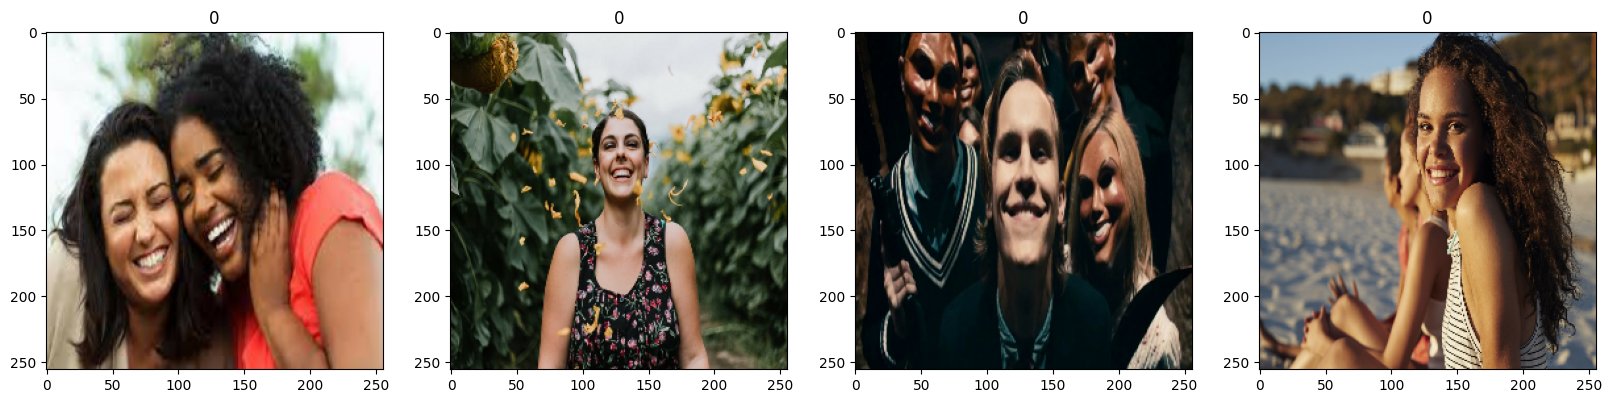

In [14]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [ ]:
data = data.map(lambda x,y: (x/255, y))

In [16]:
data.as_numpy_iterator().next()

(array([[[[0.54901963, 0.6509804 , 0.7490196 ],
          [0.54901963, 0.6509804 , 0.7490196 ],
          [0.54901963, 0.6509804 , 0.7490196 ],
          ...,
          [0.43206188, 0.26868874, 0.16078432],
          [0.49977022, 0.29193473, 0.16078432],
          [0.53231466, 0.32054994, 0.17966452]],
 
         [[0.54901963, 0.6509804 , 0.7490196 ],
          [0.54901963, 0.6509804 , 0.7490196 ],
          [0.54901963, 0.6509804 , 0.7490196 ],
          ...,
          [0.42674074, 0.26336756, 0.15546316],
          [0.4932875 , 0.28545204, 0.15430161],
          [0.527743  , 0.3159783 , 0.17509289]],
 
         [[0.5501455 , 0.6521063 , 0.75014555],
          [0.5501455 , 0.6521063 , 0.75014555],
          [0.5501455 , 0.6521063 , 0.75014555],
          ...,
          [0.4189679 , 0.25559473, 0.14769033],
          [0.48506433, 0.27722886, 0.14607844],
          [0.5198641 , 0.30809936, 0.16721396]],
 
         ...,
 
         [[0.27003744, 0.2534745 , 0.2528924 ],
          [0.2693 

# 5. Split Data

In [17]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [18]:
train_size

7

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [20]:
train


<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [22]:
model = Sequential()


In [23]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [28]:
logdir='logs'

In [29]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [30]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/20
7/7 [==============================] - 12s 495ms/step - loss: 1.0403 - accuracy: 0.5580 - val_loss: 0.6803 - val_accuracy: 0.4062
Epoch 2/20
7/7 [==============================] - 7s 685ms/step - loss: 0.6587 - accuracy: 0.5759 - val_loss: 0.6341 - val_accuracy: 0.5469
Epoch 3/20
7/7 [==============================] - 6s 513ms/step - loss: 0.6041 - accuracy: 0.6830 - val_loss: 0.5642 - val_accuracy: 0.6875
Epoch 4/20
7/7 [==============================] - 5s 510ms/step - loss: 0.5747 - accuracy: 0.6920 - val_loss: 0.4299 - val_accuracy: 0.7656
Epoch 5/20
7/7 [==============================] - 7s 529ms/step - loss: 0.4780 - accuracy: 0.7991 - val_loss: 0.4562 - val_accuracy: 0.7656
Epoch 6/20
7/7 [==============================] - 5s 509ms/step - loss: 0.5027 - accuracy: 0.7857 - val_loss: 0.4049 - val_accuracy: 0.7969
Epoch 7/20
7/7 [==============================] - 6s 607ms/step - loss: 0.4160 - accuracy: 0.8929 - val_loss: 0.3719 - val_accuracy: 0.9531
Epoch 8/20
7/7 [===

# 8. Plot Performance


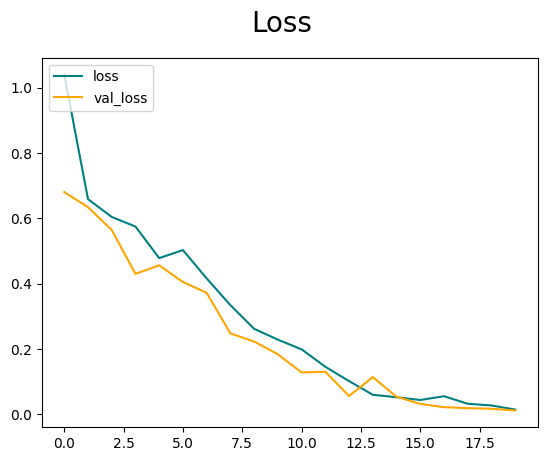

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

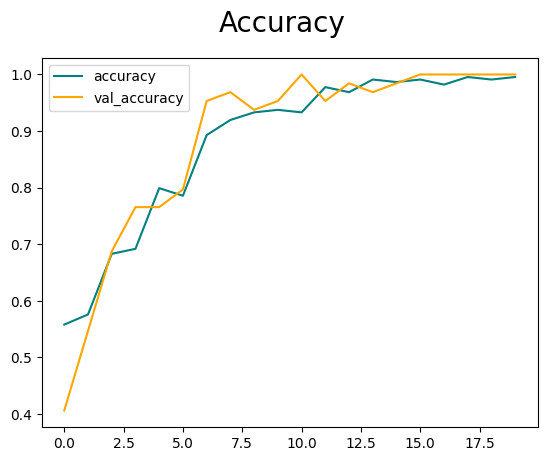

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [35]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 429ms/step


In [36]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [37]:
import cv2


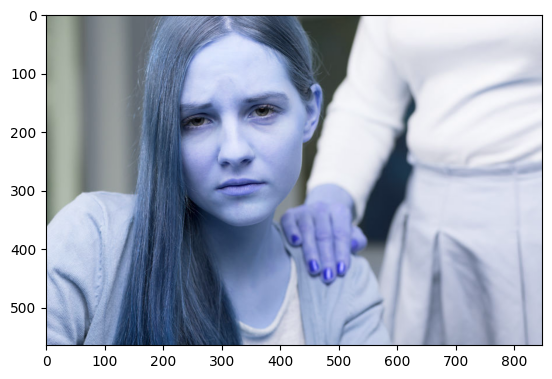

In [60]:
img = cv2.imread('/content/ImageClassification/data/sad/51079685_M.jpg')
plt.imshow(img)
plt.show()

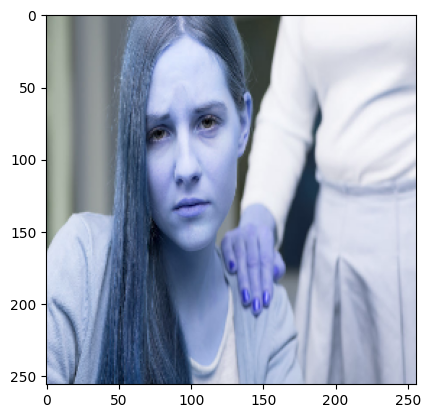

In [61]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [62]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 18ms/step


In [63]:
yhat


array([[0.99927455]], dtype=float32)

In [64]:
if yhat > 0.5:
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','imageclassifier.h5'))


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
new_model = load_model('/content/models/imageclassifier.h5')


In [53]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 81ms/step


array([[0.70066184]], dtype=float32)